In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.base_cost_models as bcm

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

In [45]:
def get_base_raw_income(power, total_pledge_needed_for_power):
    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=0.20,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=20.0,
        supply_lock_target=0.3
    )

    base_strategy = StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, 3 * YEAR, False)
    base_miner_factory = BaseMinerState.factory(balance=total_pledge_needed_for_power)
    baseline_cfg = SimConfig(
        network=network,
        strategy=base_strategy,
        miner_factory=base_miner_factory,
    )
    base_stats = Simulator(baseline_cfg).run_all(days, stats_interval)
    return base_stats

def get_base_apy_model_income(power, total_pledge_needed_for_power, pledge_borrowed, 
                              borrow_cost_aer_pct=20):
    base_stats = get_base_raw_income(power, total_pledge_needed_for_power)

    # apply cost model(s) on top of this
    borrow_cost_aer = borrow_cost_aer_pct/100.
    income_apy_model = bcm.compute_income_borrow_apy(
        base_stats, 
        pledge_borrowed,
        apy=borrow_cost_aer, 
        sampling_rate_days=1)
    borrow_apy_income = np.array(income_apy_model)
    
    return borrow_apy_income

def get_revenue_take_model_income(power, total_pledge_needed_for_power, pledge_borrowed, 
                                  repayment_cap=1.4, take_rate=0.40):
    base_stats = get_base_raw_income(power, total_pledge_needed_for_power)
    
    income_take_rewards_model, repay_remaining_vector = bcm.compute_income_take_rewards(
        base_stats,
        pledge_borrowed,
        repayment_cap=repayment_cap,
        take_rate=take_rate,
        sampling_rate_days=1
    )
    take_rewards_income = np.array(income_take_rewards_model)
    repay_remaining_vector = np.array(repay_remaining_vector)
    
    return take_rewards_income, repay_remaining_vector

def get_repay_stats(miner_balance, power, max_fee_reward_fraction, shortfall_take_amount, 
                    take_shortfall=True, token_lease_fee=0.2):
    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=token_lease_fee,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=20.0,
        supply_lock_target=0.3
    )
    max_repayment_term = 3. * 365 * DAY
    repay_miner_factory = RepayRatchetShortfallMinerState.factory(
        balance=miner_balance,
        max_repayment_term=max_repayment_term,
        max_fee_reward_fraction=max_fee_reward_fraction,
        reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH,
        shortfall_take_amount = shortfall_take_amount
    )

    repay_cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, take_shortfall),
        miner_factory=repay_miner_factory,
    )
    stats_repay = Simulator(repay_cfg).run_all(days, stats_interval)
    return pd.DataFrame(data=stats_repay)

In [42]:
get_repay_stats(0, 20, 0.6, 0.5)

,day,power_eib,balance,lease,pledge_locked,available,net_equity,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,1,0.000019,69.60644,69.64458,69.60644,0.0,-0.038139343,0.000000,0.0,0.038140513,139.21288,69.60644,50.0
1,2,0.000019,69.84436,69.826,69.84436,0.0,0.018363953,0.236851,0.142111,0.07638039,139.21288,69.368515,49.829998
2,3,0.000019,70.08221,70.00747,70.08221,0.0,0.07473755,0.473627,0.284176,0.114719644,139.21288,69.13067,49.66
3,4,0.000019,70.31998,70.188995,70.31998,0.0,0.13098145,0.710328,0.426197,0.1531583,139.21288,68.8929,49.489998
4,5,0.000019,70.55767,70.370575,70.55767,0.0,0.18709564,0.946954,0.568172,0.1916964,139.21288,68.655205,49.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1092,0.000019,142.51118,0.0,139.21288,3.2983093,142.51118,218.545326,33.942963,42.09106,139.21288,0.0,0.0
1092,1093,0.000019,142.67888,0.0,139.21288,3.4660034,142.67888,218.713018,33.942963,42.09106,139.21288,0.0,0.0
1093,1094,0.000019,142.84651,0.0,139.21288,3.6336365,142.84651,218.880656,33.942963,42.09106,139.21288,0.0,0.0
1094,1095,0.000019,143.0141,0.0,139.21288,3.8012238,143.0141,219.048241,33.942963,42.09106,139.21288,0.0,0.0


In [55]:
# since we normalize by power, no need to sweep power!
# feel free to double check this by sweeping it anyway
delta = 50
tibs_vec = np.arange(delta, 200+delta, delta)
# tibs_vec = [50]

external_borrow_rate_aer_vec = [15, 20, 25, 30, 35]

delta=0.1
shortfall_taken_pct_vec = np.arange(0.2,0.5+delta,delta)
max_fee_reward_fraction_vec = np.arange(0.2,0.5+delta,delta)
fee_take_rate_vec = np.arange(0.2, 0.4+delta, delta)
repayment_cap_vec = np.asarray([1.2,1.4,1.6])
repay_with_shortfall_results = {}
repay_no_shortfall_results = {}
base_apy_model_results = {}
base_takerewards_model_results = {}
pbar = tqdm(total=len(tibs_vec)*len(shortfall_taken_pct_vec))
for tibs in tibs_vec:
    for shortfall_taken_pct in shortfall_taken_pct_vec:
        max_fee_reward_frac_noop = 0.25  # confirmed this is a NOOP
        shortfall_taken_noop = 0.2
        full_balance_needed = get_repay_stats(0, tibs, max_fee_reward_frac_noop, shortfall_taken_noop).iloc[0]['pledge_required']
        shortfall_amt = shortfall_taken_pct * full_balance_needed
        
        # simulate borrowing same amount from external lender w/ the base-cost model and the baseline (Alex's implementation) cost model
        for external_borrow_rate_aer in external_borrow_rate_aer_vec:
            key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct, external_borrow_rate_aer)
            borrow_apy_income = get_base_apy_model_income(tibs, full_balance_needed, shortfall_amt, external_borrow_rate_aer)
            base_apy_model_results[key] = borrow_apy_income
            
            max_fee_reward_fraction_noop = 0.2
            token_lease_fee = external_borrow_rate_aer/100.
            shortfall_take_pct_noop = shortfall_taken_pct
            repay_no_shortfall_df = get_repay_stats(0, tibs, max_fee_reward_fraction_noop, shortfall_take_pct_noop,
                                                    take_shortfall=False, token_lease_fee=token_lease_fee)
            repay_no_shortfall_results[key] = repay_no_shortfall_df

        # simulate borrowing the same amount w/ the revenue-take cost model
        for fee_take_rate in fee_take_rate_vec:
            for repayment_cap in repayment_cap_vec:
                key = '%0.02f,%0.02f,%0.02f,%0.02f' % (tibs, shortfall_taken_pct, fee_take_rate, repayment_cap)
                revenue_take_income, repay_remaining_vector = get_revenue_take_model_income(tibs, full_balance_needed, shortfall_amt, 
                                                                                            repayment_cap=repayment_cap, take_rate=fee_take_rate)
                base_takerewards_model_results[key] = revenue_take_income
#                 print(key, shortfall_amt, revenue_take_income[-1])
            
        for max_fee_reward_fraction in max_fee_reward_fraction_vec:
            key = '%0.02f,%0.02f,%0.02f' % (tibs, max_fee_reward_fraction, shortfall_taken_pct)
            # balance controls the "lease" amount. by setting balance = 0, we are leasing
            # pledge_required * (shortfall_pct)
            # NOTE: force token_lease_fee to 0 to simulate pledge not satisfied by shortfall to be
            # coming from miner's wallet
            miner_balance = 0
            repay_df = get_repay_stats(miner_balance, tibs, max_fee_reward_fraction, shortfall_taken_pct, 
                                       take_shortfall=True,
                                       token_lease_fee=0.0)
            repay_with_shortfall_results[key] = repay_df
        pbar.update(1)

  0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


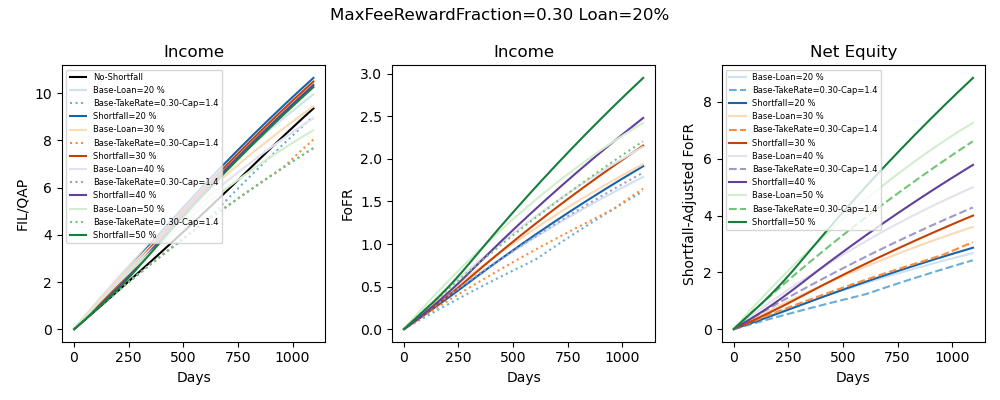

interactive(children=(FloatSlider(value=0.3, description='max_fee_reward_fraction', max=0.5, min=0.2), IntSlid…

<function __main__.update(max_fee_reward_fraction=0.3, external_borrow_rate_aer=20, tibs=50, revenue_take_rate=0.3, repayment_cap=1.4)>

In [56]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Purples'], mpl.colormaps['Greens']]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

def update(max_fee_reward_fraction=0.3, 
           external_borrow_rate_aer=20, 
           tibs=50,
           revenue_take_rate=0.3, 
           repayment_cap=1.4):
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()
    
    shortfall_taken_pct_noop = 0.2
    repay_no_shortfall_key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct_noop, external_borrow_rate_aer)
    repay_no_shortfall_df = repay_no_shortfall_results[repay_no_shortfall_key]
    repay_no_shortfall_income = repay_no_shortfall_df.iloc[1:]['net_equity']
    norm_factor=tibs
    ax[0].plot(repay_no_shortfall_income/norm_factor, color='k', label='No-Shortfall')
    
    for ii,shortfall_taken_pct in enumerate(shortfall_taken_pct_vec):
        base_key = '%0.02f,%0.02f,%d' % (tibs, shortfall_taken_pct, external_borrow_rate_aer)
        base_apy_model = base_apy_model_results[base_key]
        
        base_revenue_take_key = '%0.02f,%0.02f,%0.02f,%0.02f' % (tibs, shortfall_taken_pct, revenue_take_rate, repayment_cap)
        base_revenue_model = base_takerewards_model_results[base_revenue_take_key]

        repay_key = '%0.02f,%0.02f,%0.02f' % (tibs, max_fee_reward_fraction, shortfall_taken_pct)
        repay_df = repay_with_shortfall_results[repay_key]
        
        base_apy_income = base_apy_model  # rewards - costs
        base_revenue_income = base_revenue_model
        repay_income = repay_df.iloc[1:]['net_equity']

        norm_factor = tibs
        ax[0].plot(base_apy_income/norm_factor, color=colors[ii](0.2), label='Base-Loan=%d %%' % (shortfall_taken_pct*100,))
        ax[0].plot(base_revenue_model/norm_factor, color=colors[ii](0.5), linestyle=':', label='Base-TakeRate=%0.02f-Cap=%0.01f' % (revenue_take_rate,repayment_cap))
        ax[0].plot(repay_income/norm_factor, color=colors[ii](0.8), label='Shortfall=%d %%' % (shortfall_taken_pct*100,))
        
        norm_factor = float(repay_df.iloc[0]['pledge_locked'])
        ax[1].plot(base_apy_income/norm_factor, color=colors[ii](0.2), label='Base-Loan=%d %%' % (shortfall_taken_pct*100,))
        ax[1].plot(base_revenue_model/norm_factor, color=colors[ii](0.5), linestyle=':', label='Base-TakeRate=%0.02f-Cap=%0.01f' % (revenue_take_rate,repayment_cap))
        ax[1].plot(repay_income/norm_factor, color=colors[ii](0.8), label='Shortfall=%d %%' % (shortfall_taken_pct*100,))
        
        # shortfall_adjusted_FoFR = FoFR * (1+s)/(1-s)
        # Note that b/c the normalization factor in the equations below is divided by, we invert the fraction
        # to compute the desired quantity
        norm_factor = float(repay_df.iloc[0]['pledge_locked']) * (1.0-shortfall_taken_pct)/(1.0+shortfall_taken_pct)
        ax[2].plot(base_apy_income/norm_factor, color=colors[ii](0.2), label='Base-Loan=%d %%' % (shortfall_taken_pct*100,))
        ax[2].plot(base_revenue_model/norm_factor, color=colors[ii](0.5), linestyle='--', label='Base-TakeRate=%0.02f-Cap=%0.01f' % (revenue_take_rate,repayment_cap))
        ax[2].plot(repay_income/norm_factor, color=colors[ii](0.8), label='Shortfall=%d %%' % (shortfall_taken_pct*100,))
        
    ax[0].legend(fontsize=6)
    ax[0].set_ylabel('FIL/QAP')
    ax[0].set_title('Income')
    ax[0].legend(fontsize=6)
    ax[0].set_xlabel('Days')

    ax[1].set_ylabel('FoFR')
    ax[1].set_xlabel('Days')
    ax[1].set_title('Income')
    
    ax[2].legend(fontsize=6)
    ax[2].set_ylabel('Shortfall-Adjusted FoFR')
    ax[2].set_xlabel('Days')
    ax[2].set_title('Net Equity')

    plt.suptitle('MaxFeeRewardFraction=%0.02f Loan=%d%%' % (max_fee_reward_fraction,external_borrow_rate_aer))
    plt.tight_layout()
    fig.canvas.draw_idle()

update()
interact(update, 
         max_fee_reward_fraction=(0.2,0.5,0.1), 
         external_borrow_rate_aer=(15,35,5),
         tibs=(50,200,50),
         revenue_take_rate=(0.2, 0.4, 0.1),
         repayment_cap=(1.2,1.6,0.2))